# Scenario "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation"



| Data Set | Train trjectories | Test trajectories | Conditions      | Fault Mode                             |
|----------|:-----------------:|------------------:|-----------------|----------------------------------------|
| FD001    |        100        |               100 | ONE (Sea Level) | ONE (HPC Degradation)                  |
| FD002    |        260        |               259 | SIX             | ONE (HPC Degradation)                  |
| FD003    |        100        |               100 | ONE (Sea Level) | TWO (HPC Degradation, Fan Degradation) |
| FD004    |        248        |               249 | SIX             | TWO (HPC Degradation, Fan Degradation) |



## Experimental Scenario

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine ñ i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.

The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

| Column| Train trjectories | 
|----------|:-----------------|
| 1    |        unit number        |   
| 2    |        time, in cycles        |     
| 3    |        operational setting 1        |   
| 4    |        operational setting 2        |             
| 5    |        operational setting 3        |           
| 6    |        sensor measurement  1        |              
| 7    |        sensor measurement  2        |             
| 26   |        sensor measurement  3        |              


References: 

1. A. Saxena, K. Goebel, D. Simon, and N. Eklund, "Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation", in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.
2. NASA Ames Prognostics data repository, retrieved Oct. 2011, http://ti.arc.nasa.gov/tech/dash/pcoe/prognostic-datarepository/
3. [Major Challenges in Prognostics: Study on Benchmarking Prognostics Datasets](https://www.phmsociety.org/sites/phmsociety.org/files/phm_submission/2012/phmce_12_004.pdf), O. F. Eker1, F. Camci, and I. K. Jennions1
4. [Big Data Analytics for eMaintenance : Modeling of high-dimensional data streams.](	
http://goo.gl/kgvoMt) / Zhang, Liangwei.
Luleå : Luleå tekniska universitet, 2015. 46 p. (Licentiate thesis / Luleå University of Technology).
Publication: Research › Licentiate thesis
5. Microsoft Cortana example with the same dataset [Link](https://gallery.cortanaanalytics.com/Collection/Predictive-Maintenance-Template-3?share=1)
6. H2o.io example with the same dataset [Link](https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/python-munging-modeling-pipelines/Munging-Modeling-Pipelines-Using-H2O-Pipelines.ipynb) [Presentation](https://www.youtube.com/watch?v=KqLXFglgNqk)



In [1]:
import findspark
findspark.init()
import pyspark
sc = pyspark.SparkContext()

In [11]:
# Setup the column names of the training file
index_columns_names =  ["id","cycle"]
operational_settings_columns_names = ["setting"+str(i) for i in range(1,4)]
sensor_measure_columns_names =["s"+str(i) for i in range(1,22)]
sensor_measure_meancolumns_names =["a"+str(i) for i in range(1,22)]
sensor_measure_sdeccolumns_names =["sd"+str(i) for i in range(1,22)]

input_file_column_names = index_columns_names + operational_settings_columns_names + sensor_measure_columns_names

# And the name of the to be engineered target variable
dependent_var = ['rul']

In [2]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

scaledDF = sqlContext.read.parquet('/share/tedsds/scaleddf')
scaledDF.describe('setting1','s1','a1','sd1').toPandas()

,summary,setting1,s1,a1,sd1
0,count,20631,20631,20631,20631
1,mean,-8.870146866366143E-6,518.6699999999989,518.6699999999989,0.0
2,stddev,0.0021873134490151447,0.0,0.0,0.0
3,min,-0.0087,518.67,518.67,0.0
4,max,0.0087,518.67,518.67,0.0


In [20]:
fraction = 1000.0 / scaledDF.count()
pf = scaledDF.select(dependent_var+operational_settings_columns_names+sensor_measure_columns_names).sample(fraction=fraction, withReplacement=False, seed=123456).toPandas()



In [22]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set() 

def labels(x, y, *axes):
    for axis in axes:
        if x: axis.set_xlabel(x)
        if y: axis.set_ylabel(y)


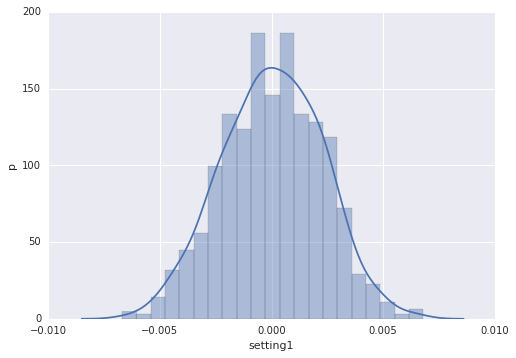

In [23]:
ax = sns.distplot(pf[["setting1"]])
labels("setting1", "p", ax)

In [21]:
pf_corr = pf.corr(method='pearson')
pf_corr

,rul,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,
rul,1.000000e+00,3.941810e-02,-2.013409e-02,NaN,-1.231836e-16,-6.624573e-01,-5.778602e-01,-6.892808e-01,2.872878e-16,-1.204324e-01,6.728745e-01,-5.591396e-01,-3.817767e-01,-4.103693e-16,-7.105003e-01,6.984828e-01,-5.735626e-01,-2.886305e-01,-6.601166e-01,2.774372e-16,...
setting1,3.941810e-02,1.000000e+00,1.174338e-01,NaN,1.461191e-18,2.315328e-03,-5.634903e-02,-5.775475e-02,-9.333576e-18,4.412012e-03,9.272468e-03,-4.451666e-02,-3.103276e-02,-2.532565e-17,-2.625725e-02,4.865301e-02,-2.290079e-02,-3.132184e-02,-2.104336e-02,6.113014e-18,...
setting2,-2.013409e-02,1.174338e-01,1.000000e+00,NaN,3.280457e-17,5.663889e-02,3.381729e-02,4.172080e-02,4.621525e-18,1.849490e-02,-2.437736e-02,7.210664e-02,-3.431018e-02,3.021700e-17,6.817524e-02,-5.954993e-02,8.739766e-02,-5.879195e-02,6.129014e-02,-2.883405e-17,...
setting3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...
s1,-1.231836e-16,1.461191e-18,3.280457e-17,NaN,1.000000e+00,-6.114248e-13,2.520547e-13,-7.554850e-14,-1.000000e+00,-2.125343e-10,-4.747189e-13,-1.673043e-11,5.406840e-14,1.000000e+00,-1.532773e-14,8.803658e-13,-8.448007e-11,6.060870e-13,3.121571e-14,-1.000000e+00,...
s2,-6.624573e-01,2.315328e-03,5.663889e-02,NaN,-6.114248e-13,1.000000e+00,6.077469e-01,7.308778e-01,6.114277e-13,9.130557e-02,-7.202950e-01,6.932731e-01,2.736569e-01,-6.114093e-13,7.515974e-01,-7.491408e-01,6.911455e-01,1.715173e-01,7.123176e-01,6.114179e-13,...
s3,-5.778602e-01,-5.634903e-02,3.381729e-02,NaN,2.520547e-13,6.077469e-01,1.000000e+00,6.853349e-01,-2.520731e-13,1.175885e-01,-6.562015e-01,6.109054e-01,2.900008e-01,2.520341e-13,6.909551e-01,-6.817207e-01,6.067841e-01,1.992950e-01,6.525744e-01,-2.520331e-13,...
s4,-6.892808e-01,-5.775475e-02,4.172080e-02,NaN,-7.554850e-14,7.308778e-01,6.853349e-01,1.000000e+00,7.550511e-14,1.587325e-01,-7.924561e-01,7.279311e-01,3.010641e-01,-7.555090e-14,8.363682e-01,-8.093775e-01,7.281611e-01,1.916774e-01,7.608480e-01,7.547364e-14,...
s5,2.872878e-16,-9.333576e-18,4.621525e-18,NaN,-1.000000e+00,6.114277e-13,-2.520731e-13,7.550511e-14,1.000000e+00,2.125343e-10,4.747148e-13,1.673043e-11,-5.401187e-14,-1.000000e+00,1.533675e-14,-8.803813e-13,8.448007e-11,-6.060888e-13,-3.114729e-14,1.000000e+00,...
s6,-1.204324e-01,4.412012e-03,1.849490e-02,NaN,-2.125343e-10,9.130557e-02,1.175885e-01,1.587325e-01,2.125343e-10,1.000000e+00,-1.432639e-01,1.306370e-01,2.219010e-02,-2.125343e-10,1.776868e-01,-1.433655e-01,1.340415e-01,2.566258e-03,1.620603e-01,2.125343e-10,...


The formula for calculating the [Pearson Correlation][pearson] between two sets of data can be expressed as:

$$r = r_{xy} =\frac{\sum ^n _{i=1}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum ^n _{i=1}(x_i - \bar{x})^2} \sqrt{\sum ^n _{i=1}(y_i - \bar{y})^2}}$$

This text is Markdown and rendered as a presentation via the [RISE][rise] Jupyter extension. In addition to basic Markdown, mathematics can be rendered which is useful when talking to a technical audience.

[rise]: https://github.com/damianavila/RISE
[pearson]: https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient

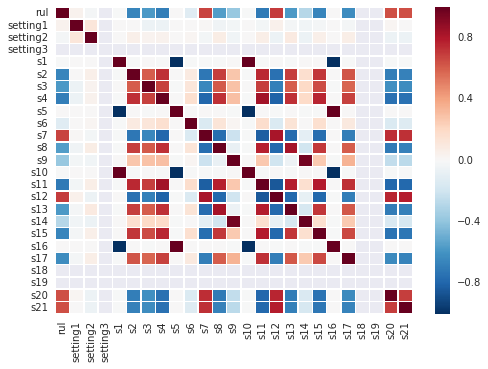

In [25]:
sns.heatmap(pf_corr,linewidths=.5);


# The sensor data does not show any trends over time, making it difficult to make predictions about the future from the observed data


In [28]:
fraction = 1000.0 / scaledDF.count()
pf2 = scaledDF.sample(fraction=fraction, withReplacement=False, seed=123456).toPandas()



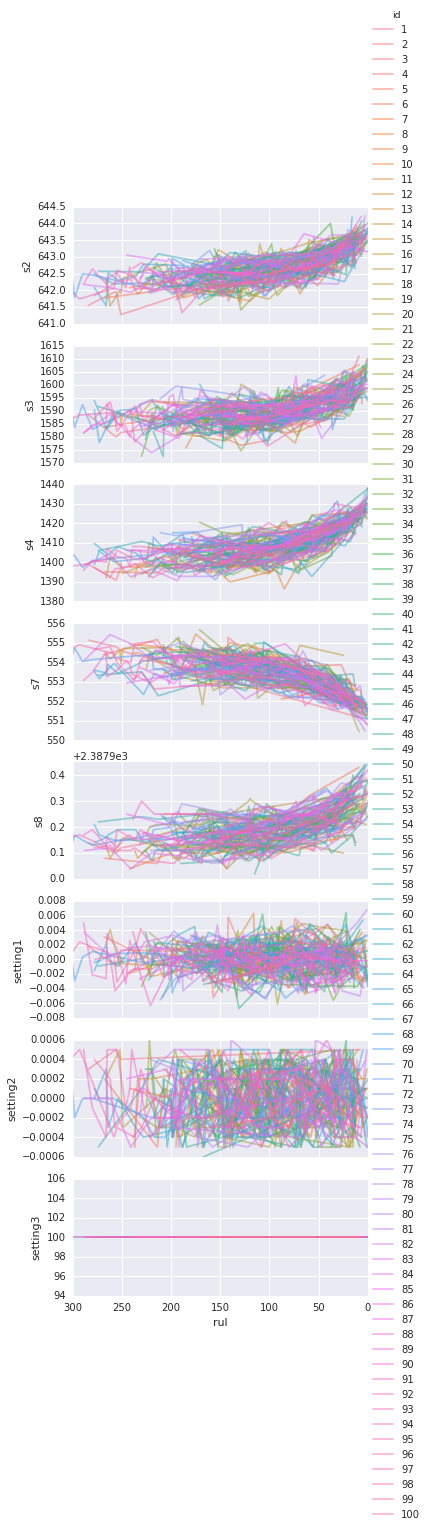

In [33]:

g = sns.PairGrid(data=pf2,
                 x_vars=dependent_var,
                 y_vars=sensor_measure_columns_names + \
                        operational_settings_columns_names,
                 hue="id", size=2, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

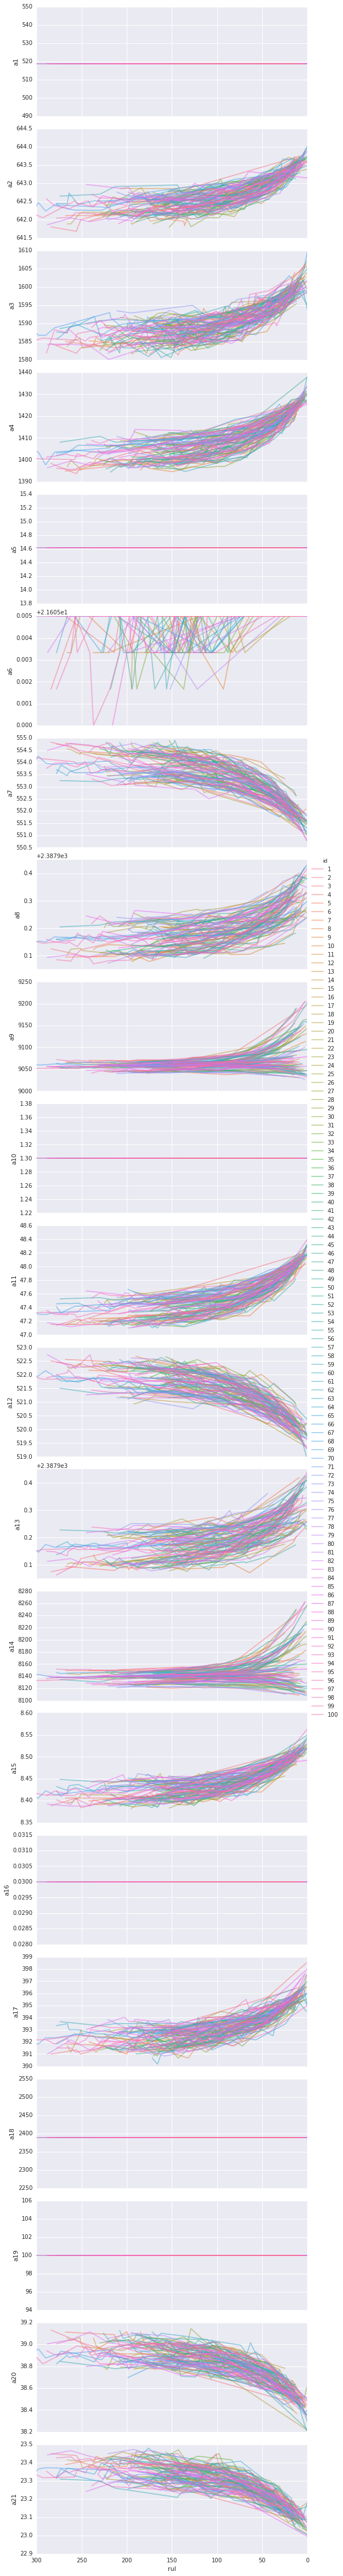

In [34]:

g = sns.PairGrid(data=pf2,
                 x_vars=dependent_var,
                 y_vars=sensor_measure_meancolumns_names,
                 hue="id", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(300,0))
g = g.add_legend()

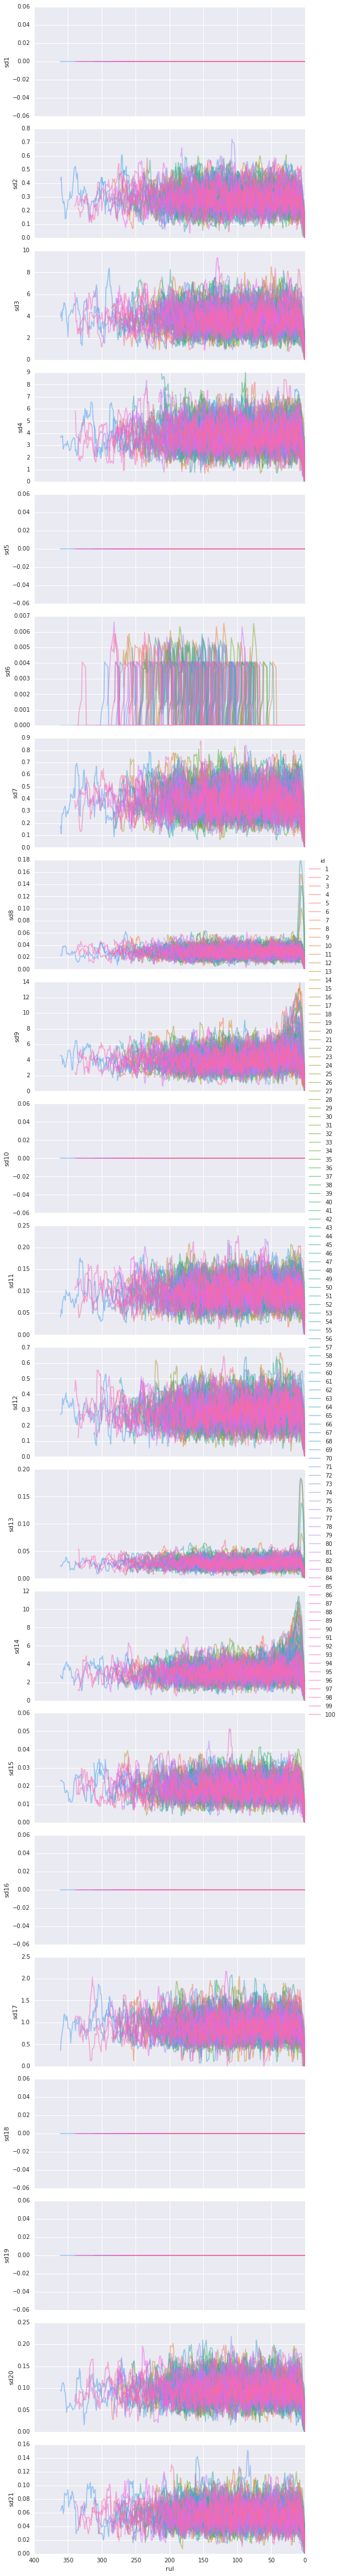

In [32]:

g = sns.PairGrid(data=scaledDF.toPandas(),
                 x_vars=dependent_var,
                 y_vars=sensor_measure_sdeccolumns_names,
                 hue="id", size=3, aspect=2.5)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(400,0))
g = g.add_legend()

# The sensor measurements happen in 6 clusters; this open investigation coincides with the operating modes


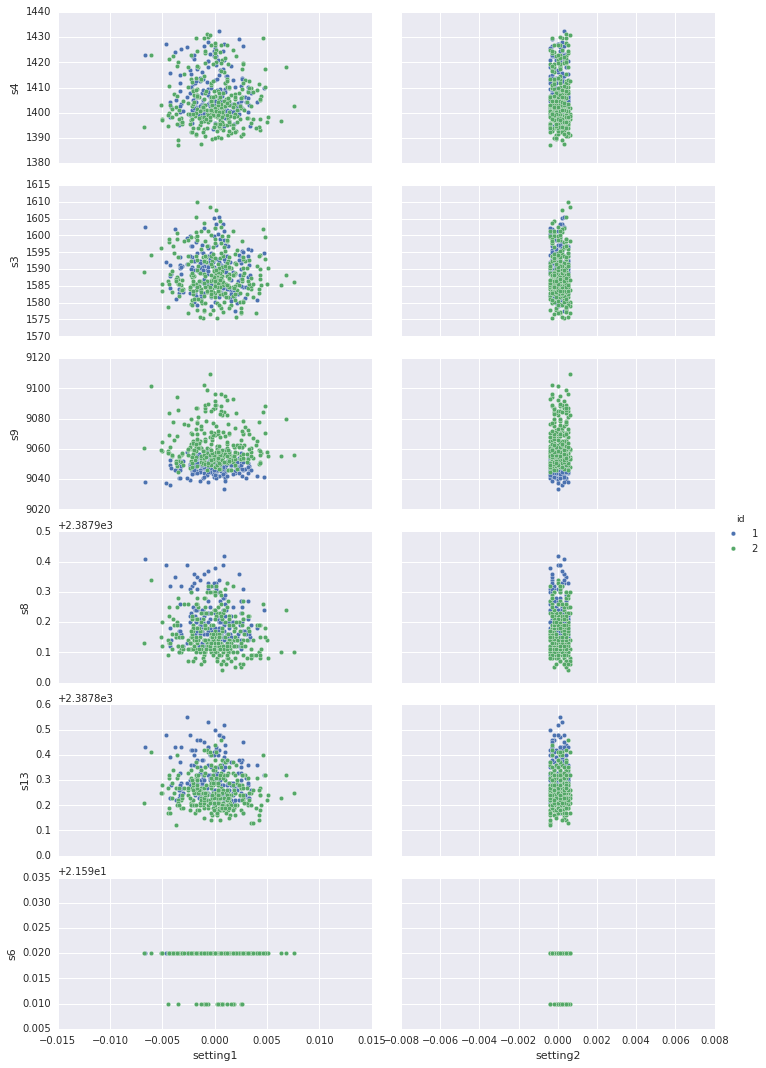

In [26]:

g = sns.pairplot(data=scaledDF.filter(scaledDF.id < 3).toPandas(),
                 x_vars=["setting1","setting2"],
                 y_vars=["s4", "s3", 
                         "s9", "s8", 
                         "s13", "s6"],
                 hue="id", aspect=2)

In [37]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS, LogisticRegressionModel
from pyspark.mllib.regression import LabeledPoint
lgregWithLBFGS = LogisticRegressionModel.load(sc, "/share/tedsds/savedmodelMulticlassMetricsExamplesaved")

labelsAndPreds = parsedData.map(lambda p: (p.label, model.predict(p.features)))
trainErr = labelsAndPreds.filter(lambda (v, p): v != p).count() / float(parsedData.count())
print("Training Error = " + str(trainErr))

In [ ]:

labelsAndScores = OHEValidationData.map(lambda lp:
                                            (lp.label, getP(lp.features, model0.weights, model0.intercept)))
labelsAndWeights = labelsAndScores.collect()
labelsAndWeights.sort(key=lambda (k, v): v, reverse=True)
labelsByWeight = np.array([k for (k, v) in labelsAndWeights])

length = labelsByWeight.size
truePositives = labelsByWeight.cumsum()
numPositive = truePositives[-1]
falsePositives = np.arange(1.0, length + 1, 1.) - truePositives

truePositiveRate = truePositives / numPositive
falsePositiveRate = falsePositives / (length - numPositive)

# Generate layout and plot data
fig, ax = preparePlot(np.arange(0., 1.1, 0.1), np.arange(0., 1.1, 0.1))
ax.set_xlim(-.05, 1.05), ax.set_ylim(-.05, 1.05)
ax.set_ylabel('True Positive Rate (Sensitivity)')
ax.set_xlabel('False Positive Rate (1 - Specificity)')
plt.plot(falsePositiveRate, truePositiveRate, color='#8cbfd0', linestyle='-', linewidth=3.)
plt.plot((0., 1.), (0., 1.), linestyle='--', color='#d6ebf2', linewidth=2.)  # Baseline model